In [1]:
import pandas as pd
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
import multiprocessing
import copy
from tqdm import tqdm
import time
from math import sqrt
from skimage import io 
from PIL import Image, ImageFilter
import random
from keras.preprocessing.image import ImageDataGenerator 
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

%matplotlib inline

## Visualisation and Modification



In this section, we will begin by loading the preprocessed data exported from section 2 and running this through a relatively simple neural network. We then aim to analyse the predictive output of this model and other models in order to gain an insight into what areas the model performs well, and what areas the model could be improved upon

We begin by loading in the preprocessed data as our training data, and then using non-preprocessed testing data to test prediction accuracy. To save on memory, we reduce the size of the images to 100x100 pixels

In [2]:
# LOADING THE DATA

#Defining our four class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

#No. of classes
nb_classes = len(class_names)

#Image pixel width x height
IMAGE_SIZE = (150, 150)

#Loading Training and Testing folders
datasets = ['/kaggle/input/processed-brain-data/Training','/kaggle/input/brain-tumor-mri-dataset/Testing']
output = []
#Perform for both Training and Testing
for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        #Searching through each folder corresponding to a class
        for folder in class_names:
            label = class_names_label[folder]
            
            #Searching through every image within the folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Getting path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Opening and resizing image
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its label to the output
                images.append(image)
                labels.append(label)
        
        #Convert to array
        images = np.array(images)
        labels = np.array(labels)   
        
        output.append((images, labels))

#Define training and testing images and labels
#(train_images, train_labels) = output
#train_images = output[0][0]
#train_labels = output[0][1]
(train_images, train_labels), (test_images, test_labels) = output

Loading /kaggle/input/processed-brain-data/Training


100%|██████████| 5893/5893 [00:40<00:00, 143.97it/s]


Loading /kaggle/input/brain-tumor-mri-dataset/Testing


100%|██████████| 300/300 [00:02<00:00, 124.80it/s]


By checking the first few images within our training set, we can see that although the quality has been reduced, the images still contain enough information that we can hope the model will still perform well.

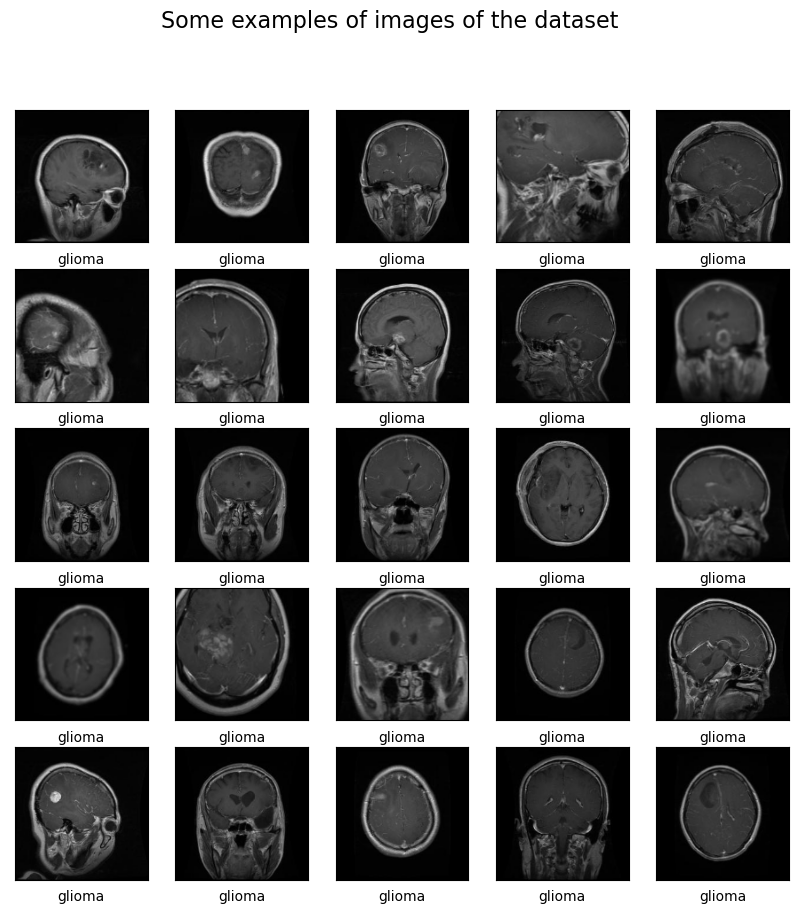

In [3]:
#CHECKING IMAGES
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names,train_images,train_labels)

We begin by defining a simple CNN using keras. Here we only include a few hidden layers: two convolution layers, two maxpooling layers, a flatten layer and two dense layers, using 'relu' activation functions for all except a 'softmax' function in the final layer.

For compiling, we use the 'ADAM' optimiser and sparse categorical cross-entropy for the loss function.

We can see how the shape of the data and amount of parameters changes in each layer using the flowchart and model summary below.

In [4]:
#BUILDING INITIAL MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

#Compiling model
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

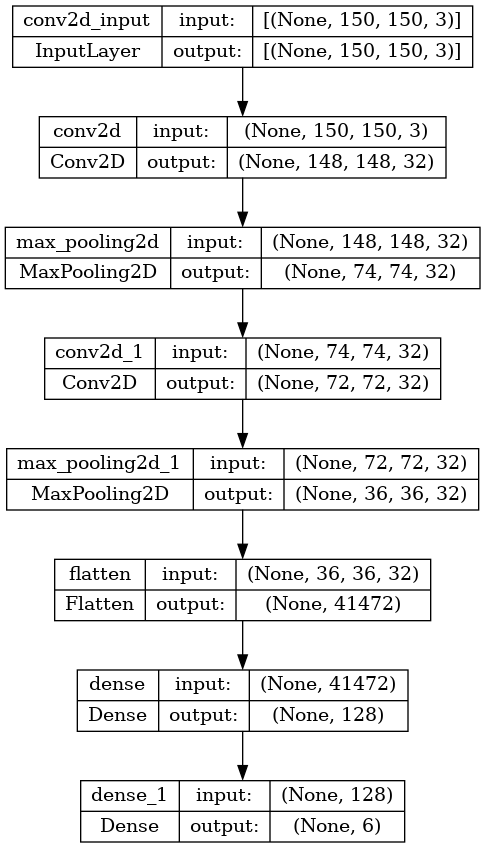

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB')

Finally we are ready to train the model on the training data images and labels. Here we use 20% of the data as a validation set to check the how the loss increases on new data. As for the training set, we use a batch size of 55 images and run the process for 20 iterations. 

In [7]:
#TRAINING CNN
cnn = model.fit(train_images, train_labels, batch_size=55, epochs=20, validation_split = 0.2)

Epoch 1/20
336/336 [==============================] - 14s 20ms/step - loss: 6.6281 - accuracy: 0.7441 - val_loss: 1.1398 - val_accuracy: 0.5699
Epoch 2/20
336/336 [==============================] - 6s 17ms/step - loss: 0.2963 - accuracy: 0.8909 - val_loss: 0.9500 - val_accuracy: 0.6756
Epoch 3/20
336/336 [==============================] - 6s 17ms/step - loss: 0.1317 - accuracy: 0.9566 - val_loss: 0.9762 - val_accuracy: 0.7514
Epoch 4/20
336/336 [==============================] - 6s 17ms/step - loss: 0.0676 - accuracy: 0.9790 - val_loss: 1.3136 - val_accuracy: 0.7170
Epoch 5/20
336/336 [==============================] - 6s 17ms/step - loss: 0.0540 - accuracy: 0.9828 - val_loss: 1.4835 - val_accuracy: 0.7142
Epoch 6/20
336/336 [==============================] - 6s 17ms/step - loss: 0.0441 - accuracy: 0.9867 - val_loss: 1.8059 - val_accuracy: 0.6659
Epoch 7/20
336/336 [==============================] - 6s 18ms/step - loss: 0.0363 - accuracy: 0.9902 - val_loss: 1.7041 - val_accuracy: 0.693

We can use the validation set to check the relative increase in loss in the validation set as the loss within the training set is minimised. Here we can see that this increase is quite high relative to the optimisation of the training loss.

<function matplotlib.pyplot.show(close=None, block=None)>

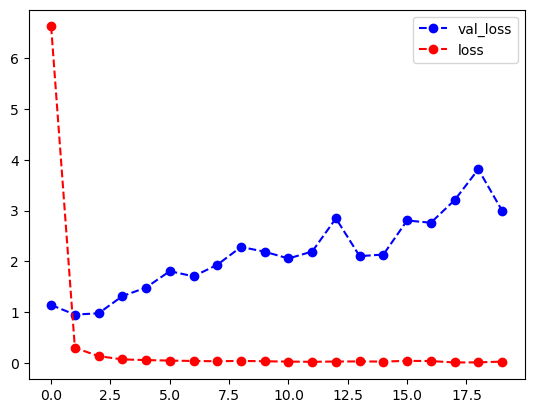

In [8]:
#PLOT ACCURACY VS LOSS

plt.plot(cnn.history['val_loss'],'bo--',label="val_loss")
plt.plot(cnn.history['loss'],'ro--',label="loss")

plt.legend()
plt.show

We then introduce our testing data from the unprocessed set, and run this through our trained CNN to get an estimate for model accuracy. In this case we achieve an accuracy of 94%. To investigate the predictions further, we can predict the class of each image by using the model to estimate probabilities for each image, then assigning it to the class with highest probability.

In [9]:
#CALCULATING TEST PREDICTION
test_loss = model.evaluate(test_images, test_labels)

predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

41/41 [==============================] - 0s 3ms/step


To get an initial idea of the kind of images which the model struggles with, we can first plot a confusion matrix. From this immedeately we can see that the model correctly predicts the image class in the vast majority of cases. Within the misindentified images, we generally find that the most confusion comes from the model trying to differentiate between different subclasses of tumours. It was very rare that a notumour was misclassified. The most common mistake was a glioma being misindentified as a meningioma, which we can see happen numerous times in the sample of images shown below.

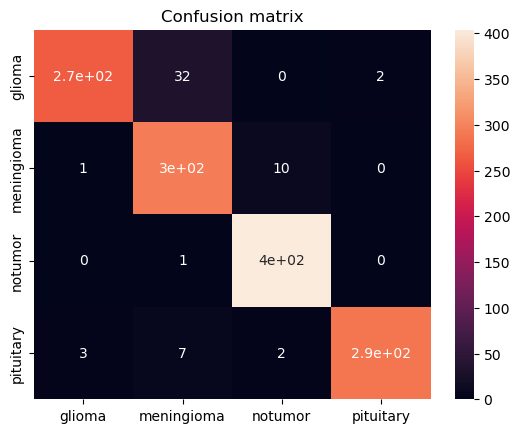

In [10]:
#PLOTTING CONFUSION MATRIX
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [11]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

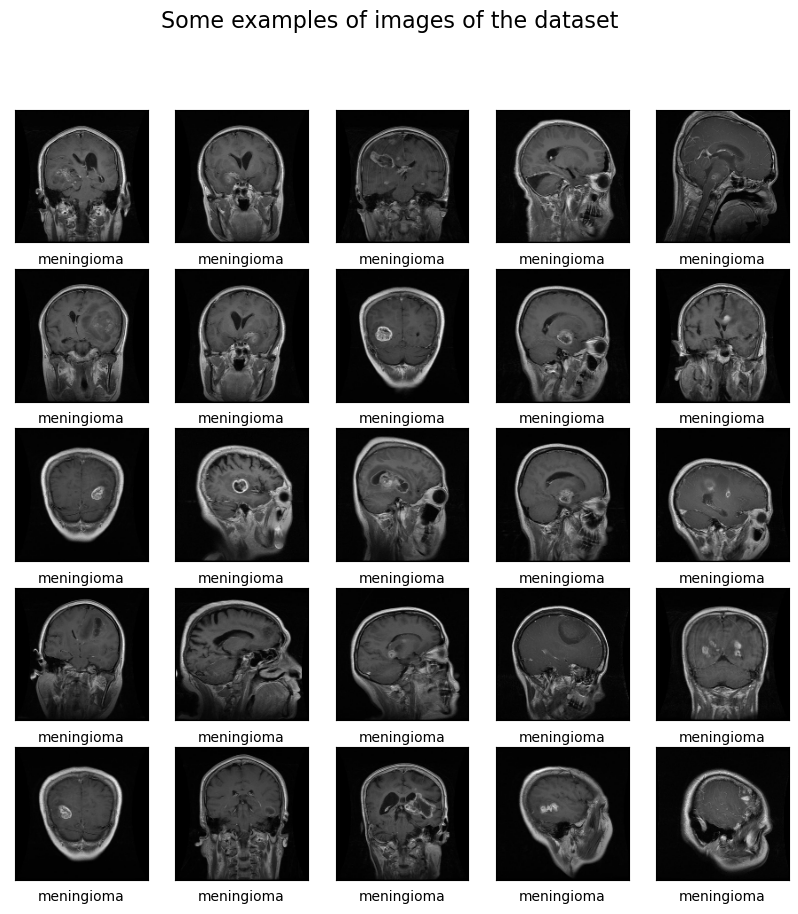

In [12]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Next we investigate the PCA plot of the features used by the CNN model. This will hopefully reaffirm our observations that the model struggles more differentiating between tumours, but is relatively successful in picking out notumour classes. 

To best show this, we need a more rigourous model. Hence we now introduce the pretrained 'VGG16' CNN accessible through the keras library. We use this to generate a much better set of features using the training data, and then decompose these features into their first and second principle components. The results can be seen in the graph below.

In [13]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
train_features = model.predict(train_images)
n_train, x, y, z = train_features.shape
numFeatures = x*y*z

722/722 [==============================] - 23s 30ms/step


In [15]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, numFeatures))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

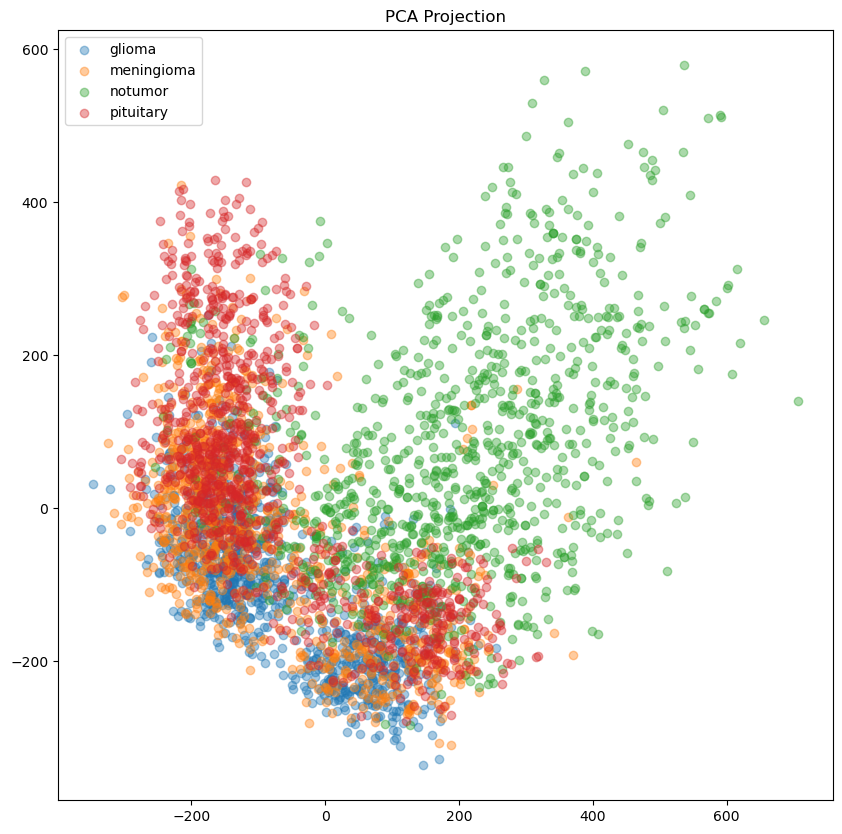

In [16]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()


The first takeaway from this plot is the incredibly high variance within the notumour data relative to the rest of the data. This backs up our idea that the model is able to spot a notumour from a tumour well, since the main cluster of nutumour points is spread very far out from the rest. However when it comes to the other points, we can see they have very little relative variance, implying that their features are all similar and that the model will struggle more in telling them apart. Looking at the left of the plot, it does seem like some cases of pituatary have features identifying them from the rest, but as for the rest of the plot, the clusters of pituatary, glioma and meningioma all pretty much overlap

Another interesting observation is the fact that this PCA plot contains two distinct clusters, one more compact cluster on the left and another cluster with higher variance on the left. Interestingly, whilst the majority of notumours are easily identifiable in the right cluster, the notumours within the left cluster have barely any more variance than the other classes. This seems to imply that there exists one major feature of the images where for one case, the model performs well, whilst in the other, it performs significantly worse. We can also attempt to remove all notumour images and rerun the analysis looking only at predicting between glioma, meningioma and pituatary. This gives the PCA plot seen below, which similarly shows all three classes clustered similarly, but still separated into two main sections.

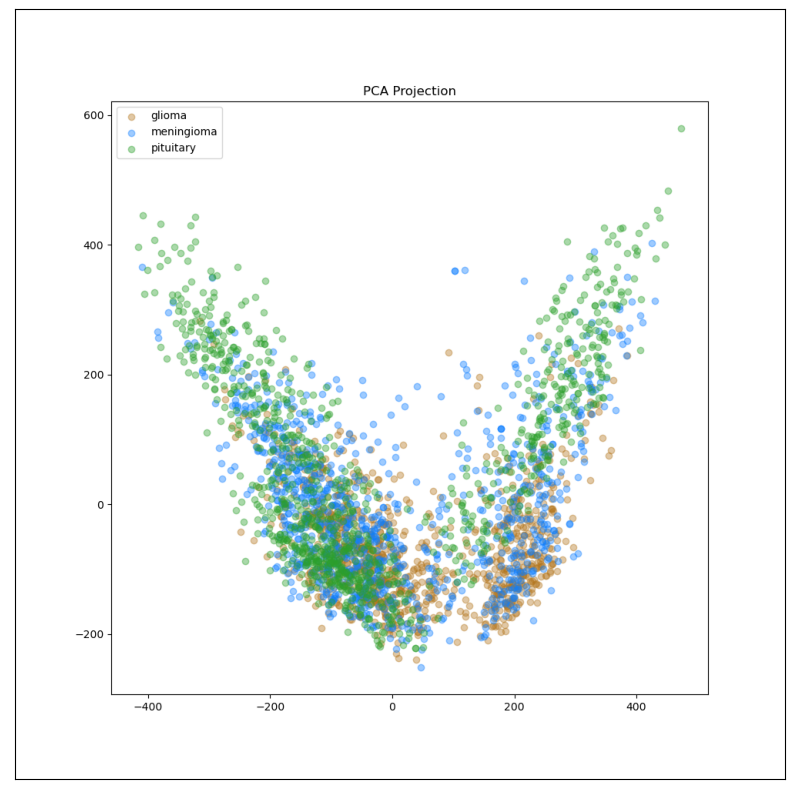

In [22]:
nonotumourgraph = cv2.imread('/kaggle/input/graph-images/PCA_nonotumour.png')
fig = plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(nonotumourgraph, cmap=plt.cm.binary)

We hypothesise that this hidden variable is the angle at which the photos were taken, as discussed in the EDA section. From the PCA plot we can see that the majority of notumour points lie within the right cluster, which the model seems to perform better in. Then when looking at the images within the notumour folder, we find that the majority of these images are taken *top down*, with the minority being side on or from the back. It seems intuitive that identifying the prescense of tumours in these top down images (which in most cases are simple circles without many other objects) would be easier than in the case of side on images (which generally contain other objects such as bones).

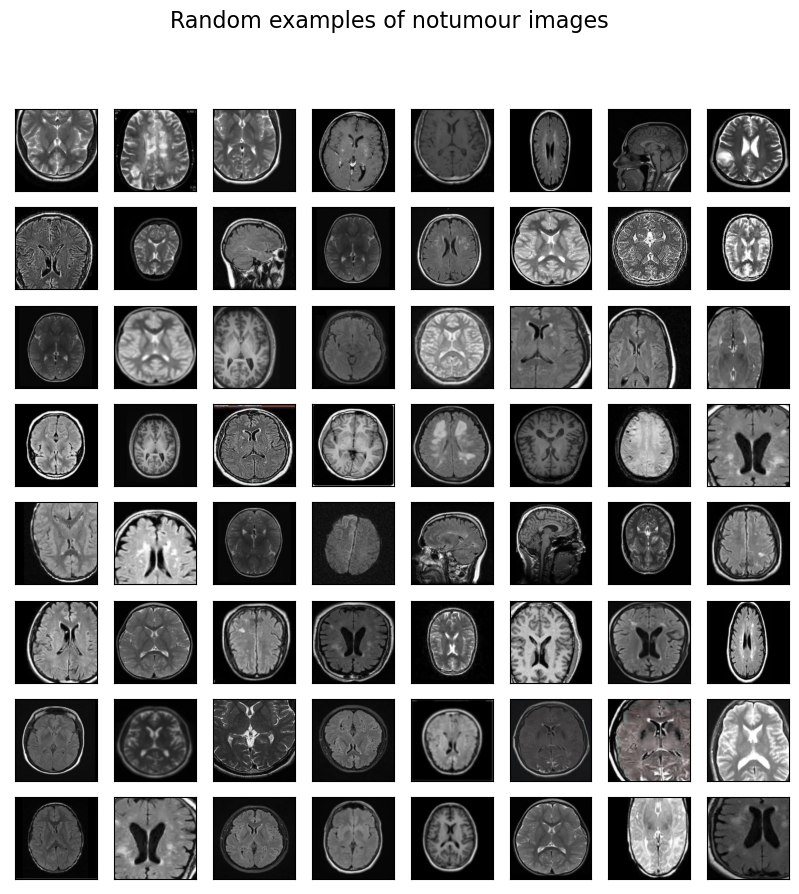

In [17]:
#PLOTTING SEVERAL RANDOM NOTUMOUR IMAGES

notumours = train_images[train_labels==2]

rand_notumours = random.sample(list(notumours),64)

fig = plt.figure(figsize=(10,10))
fig.suptitle("Random examples of notumour images", fontsize=16)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(rand_notumours[i], cmap=plt.cm.binary)
plt.show()
    

We therefore conclude that the model performs well in terms of classifying tumours versus notumours, although has limitations when differentiating between different subclasses of tumours. We have also found the potential of an extra variable: 'camera angle', being responsible for most of the variance within the features, and so the next section will be devoted to addressing this problem to see if solving it can improve model performance. 

# References

Building CNNs - https://www.kaggle.com/code/kanncaa1/deep-learning-tutorial-for-beginners

Visualisation techniques - https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras

